# Comparison of different sources for EpiCurve / date of onset of illness
The following sources are compared:
* RKI daily situation reports digitized versions of fig. 3 on page 3 or 4. Contains daily counts for known dates of onset and unknwons/asymptomatic (up to 13.04.2020) visit: mlinden.de/COVID19/ for more detailed review.
* RKI bulletin 09.04.2020 (https://www.rki.de/DE/Content/Infekt/EpidBull/Archiv/2020/17/Art_02.html) contains daily counts for knwon cases and some magic to distribute unknown/asymptomatic 
* RKI database counts from https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0 , assuming "Refdatum" is date of onset of illness. Data downloaded 13.04.2020 22:00

Observations:
* RKI arcgis Database download only contains datasets with both Refdatum and Meldedatum 91k vs. 123k cases currently reported by the RKI. Apparently only datasets with both Refdatum and Meldedatum, peak cases per day < 4500 compared to ~6000 max reported elsewhere
* 4 cases have Refdatum < 15.01.2020, 40 cases < 01.02.2020

## Disclaimer
Uses data supplied by https://github.com/Priesemann-Group/covid19_inference_forecast

In [119]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from GenByDateOfOnset import ByDateOfOnset 

# Import RKI arcgis Database dump by PriesemannGroup at MPI-DS
alt_df = pd.read_csv("arcgisData/rki_fallback.csv", sep=",")
alt_df['date'] = pd.to_datetime(alt_df['date'], format='%d-%m-%Y')

# Import RKI arcgis Database download
df = pd.read_csv("arcgisData/RKI_COVID19.csv", sep=",") 
rdate = lambda s : s.split("T")[0]
for col in ["Meldedatum","Refdatum"]:
    df[col] = df[col].apply(rdate)
    df[col] = pd.to_datetime(df[col],format="%Y-%m-%d")
df["delay"] = df["Meldedatum"]-df["Refdatum"]
print("Number of datasets in arcgis Download:%d"%(len(df)))

# Import data from digitized situation-reports
byDateOfOnset = ByDateOfOnset() 
sit_rep = byDateOfOnset.Dataset("situation_report")
rki_bulletin = byDateOfOnset.Dataset("bulletin")

print(sit_rep["datasets"].keys(),sit_rep.keys())
print(rki_bulletin["datasets"].keys(),sit_rep.keys())

def toDatetime(day):
    y,m,d,f = day//10000,(day//100)%100,day%100,28
    return datetime.date(2000+y,m,d)

# Situation report's data
sit_days = [toDatetime(d) for d in sit_rep["days"]]
latest = sit_rep["ddates"][200413] # reverse lookup the date
sit_onsets_perday_latest = np.array(sit_rep["datasets"]["onsets"][latest])
sit_unknowns_perday_latest = np.array(sit_rep["datasets"]["meldungs_raw"][latest])
idate = sit_rep["ddates"][200409]
sit_onsets_perday_200409 = np.array(sit_rep["datasets"]["onsets"][idate])
sit_unknowns_perday_200409 = np.array(sit_rep["datasets"]["meldungs_raw"][idate])

# RKI Bulletin's data
bul_days = [toDatetime(d) for d in rki_bulletin["days"]]
bul_onsets_perday_200409 = np.array(rki_bulletin["datasets"]["bydate_observed"][0])
bul_imputated_perday_200409 = np.array(rki_bulletin["datasets"]["bydate_imputiert"][0])
bul_nowcast_perday_200409 = np.array(rki_bulletin["datasets"]["bydate_Nowcast"][0])

print(sit_days[0],sit_onsets_perday_200409)
print(bul_days[0],bul_onsets_perday_200409)

Number of datasets in arcgis Download:91471
dict_keys(['infos', 'onsets_raw', 'meldungs_raw', 'onsets', 'onsets_perday', 'onsets_diff', 'meldungs_raw_diff']) dict_keys(['days', 'ddays', 'dates', 'ddates', 'datasets'])
dict_keys(['bydate_observed', 'bydate_imputiert', 'bydate_Nowcast', 'bydate_Nowcast_high', 'bydate_Nowcast_low']) dict_keys(['days', 'ddays', 'dates', 'ddates', 'datasets'])
2020-02-16 [   2    4    2    3   10    8   10   17   41   71  123  107  144  136
  140  221  211  330  335  522  682  908 1374 1726 2182 2369 2931 2980
 3034 3980 3350 3414 2941 3365 2729 2241 3113 2360 2478 2167 2133 2005
 1562 1975 1433 1419 1182  892  512  325  271   59    7    0    0    0
    0    0]
2020-02-25 [  42   77  105  126  140  161  203  245  273  301  399  532  728 1001
 1336 1756 2091 2455 2734 2923 3301 3413 3503 3154 3126 2902 2664 2580
 2462 2510 2189 2091 1923 1699 1629 1420 1336 1070  867  552]


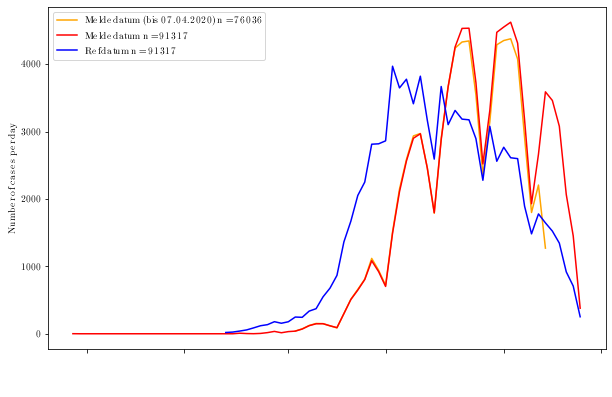

In [120]:
# Data from the arcgis-Database (current and rki_fallback.csv)
# Filter Referenzdatum > 20.02.2020
f20df = df[df["Refdatum"] > datetime.datetime(2020,2,20)]
# Filter alternate datatset from rki_fallback.csv for comparison.
falt_df = alt_df[alt_df["date"] > datetime.datetime(2020,3,1)]

fig = plt.figure(figsize=(10,7))

falt_df["date"].value_counts().plot(color="orange",label="Meldedatum (bis 07.04.2020) n = %d"%(len(falt_df)))
f20df["Meldedatum"].value_counts().plot(color="red",label="Meldedatum n = %d"%(len(f20df)))
ax = f20df["Refdatum"].value_counts().plot(color="blue",label="Refdatum n = %d"%(len(f20df)))

ax.set_ylabel("Number of cases per day")

plt.legend(loc=2)
plt.savefig("page/graph/MeldeVsRefdatum.svg")
plt.show()

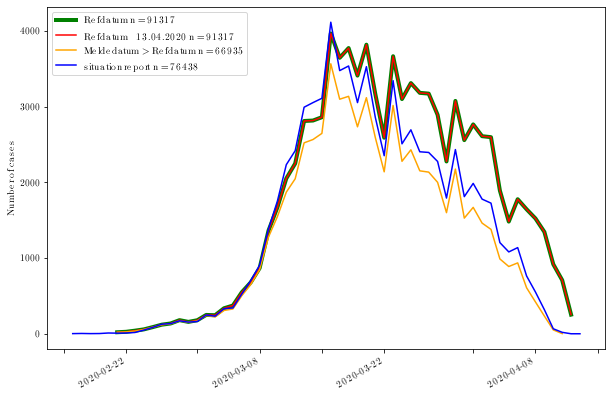

In [121]:
# Comparison between arcgis Refdatum and cases by known date of onset of illness as reported in the daily situation-reports
fig = plt.figure(figsize=(10,7))

# Filter arcgis Database Data to the same timeframe as latest (13.04.2020) situation-report
fdf = df[(df["Refdatum"] > datetime.datetime(2020,2,20)) & (df["Meldedatum"] < datetime.datetime(2020,4,13)) ]
fsdf = fdf[fdf["Refdatum"] < fdf["Meldedatum"]]

f20df["Refdatum"].value_counts().plot(linewidth=4,color="green",label="Refdatum n = %d"%(len(f20df)))
fdf["Refdatum"].value_counts().plot(color="red",label="Refdatum < 13.04.2020 n = %d"%(len(fdf)))
ax = fsdf["Refdatum"].value_counts().plot(color="orange",label="Meldedatum $>$ Refdatum  n = %d"%(len(fsdf)))

ax.plot(sit_days,sit_onsets_perday_latest,"blue",label="situation report n = %d"%(sum(sit_onsets_perday_latest)))
ax.set_ylabel("Number of cases")

plt.legend(loc=2)
pname = "arcgisVsEpiCurve"
plt.savefig("page/graph/%s.svg"%pname)
plt.savefig("%s.pdf"%pname)
plt.show()

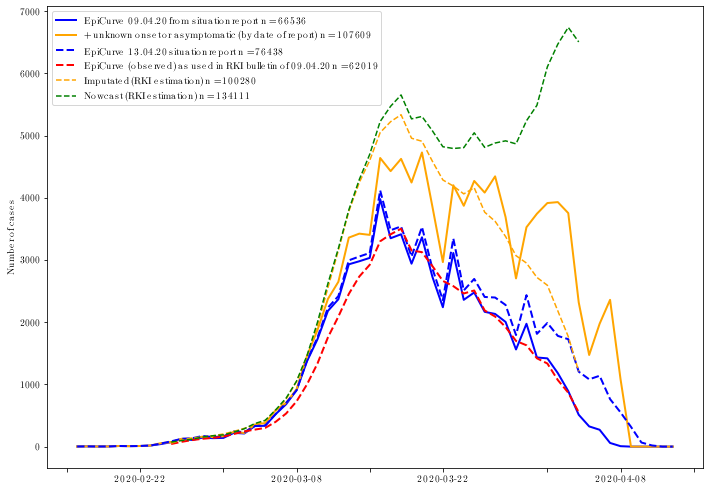

In [122]:
# Different EpiCurves from RKI publications: Situation Report and Bulletin 09.04.2020
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(wspace=0.13,hspace=0.1,left=0.07,right=0.98,top=0.965,bottom=0.05)
ax = fig.add_subplot(111)

# Situation-repot Datasets
totalepi = sit_onsets_perday_200409+sit_unknowns_perday_200409
ax.plot(sit_days,sit_onsets_perday_200409,"b",linewidth=2,label="EpiCurve 09.04.20 from situation report n = %d"%sum(sit_onsets_perday_200409))
ax.plot(sit_days,totalepi,"-",color="orange",linewidth=2,label="+ unknown onset or asymptomatic (by date of report) n = %d"%(sum(totalepi)))
ax.plot(sit_days,sit_onsets_perday_latest,"b--",linewidth=2,label="EpiCurve 13.04.20 situation report n = %d"%sum(sit_onsets_perday_latest))
# Bulletin Datasets
ax.plot(bul_days,bul_onsets_perday_200409,"r--",linewidth=2,label="EpiCurve (observed) as used in RKI bulletin of 09.04.20 n = %d"%sum(bul_onsets_perday_200409))
ax.plot(bul_days,bul_imputated_perday_200409,"r--",color="orange",label="Imputated (RKI estimation) n = %d"%sum(bul_imputated_perday_200409))
ax.plot(bul_days,bul_nowcast_perday_200409,"r--",color="green",label="Nowcast (RKI estimation) n = %d"%sum(bul_nowcast_perday_200409))

ax.set_ylabel("Number of cases")
plt.legend(loc=2)

pname = "EpiCurveVSarcgisVSbulletin200409"
plt.savefig("page/graph/%s.svg"%pname)
plt.savefig("%s.pdf"%pname)
plt.show()

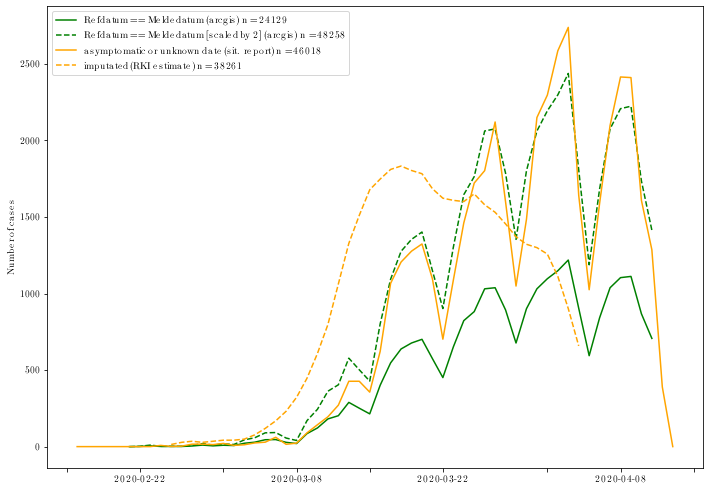

In [123]:
# Comparison of residuals: Do arcgis Datasets include asymptomatic cases but exclude unknwon date of onset?
# Situation reports combine unknown date of onset and asymptomatic cases

# Filter arcgis Database Data to the same timeframe as latest (13.04.2020) situation-report
fdf = df[(df["Refdatum"] > datetime.datetime(2020,2,20)) & (df["Meldedatum"] < datetime.datetime(2020,4,14)) ]
fsdf = fdf[fdf["Refdatum"] < fdf["Meldedatum"]]

full = fdf["Refdatum"].value_counts()
not_same_day = fsdf["Refdatum"].value_counts()

fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(wspace=0.13,hspace=0.1,left=0.07,right=0.98,top=0.965,bottom=0.05)
ax = fig.add_subplot(111)

diff = (mdata-not_same_day)
ax.plot(diff,color="green",label="Refdatum $==$ Meldedatum (arcgis) n = %d"%sum(diff[:-1]))
ax.plot(diff*2,"--",color="green",label="Refdatum $==$ Meldedatum [scaled by 2] (arcgis) n = %d"%sum(diff[:-1]*2))
ax.plot(sit_days,sit_unknowns_perday_latest,color="orange",label="asymptomatic or unknown date (sit. report) n = %d"%(sum(sit_unknowns_perday_latest)))
bulletdiff = bul_imputated_perday_200409-bul_onsets_perday_200409
ax.plot(bul_days,bulletdiff,"--",color="orange",label="imputated (RKI estimate) n = %d"%(sum(bulletdiff)))

ax.set_ylabel("Number of cases")
plt.legend(loc=2)

pname = "UnknownsArcgisVsEpiCurve"
plt.savefig("page/graph/%s.svg"%pname)
plt.savefig("%s.pdf"%pname)
plt.show()

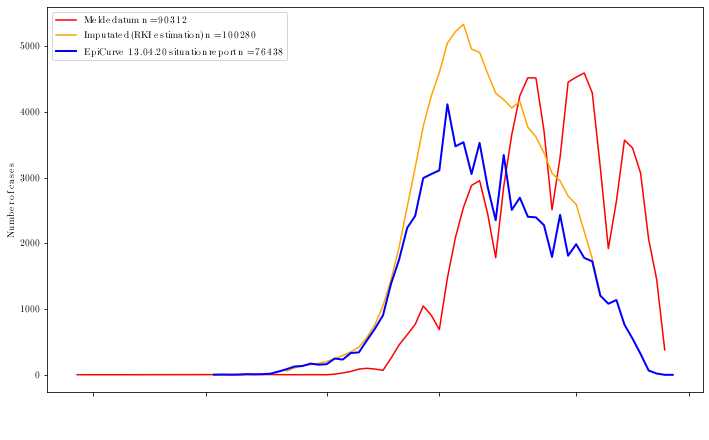

In [124]:
# Meldedatum vs. observed and Imputated EpiCurve --> Delay
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(wspace=0.13,hspace=0.1,left=0.07,right=0.98,top=0.965,bottom=0.03)

fdf = df[df["Refdatum"] > datetime.datetime(2020,3,1)] 
ax = fdf["Meldedatum"].value_counts().plot(color="red",label="Meldedatum n = %d"%(len(fdf)))
ax.plot(bul_days,bul_imputated_perday_200409,color="orange",label="Imputated (RKI estimation) n = %d"%sum(bul_imputated_perday_200409))
ax.plot(sit_days,sit_onsets_perday_latest,"b-",linewidth=2,label="EpiCurve 13.04.20 situation report n = %d"%sum(sit_onsets_perday_latest))

ax.set_ylabel("Number of cases")
plt.legend(loc=2)

pname = "EpiVsMeldung"
plt.savefig("page/graph/%s.svg"%pname)
plt.savefig("%s.pdf"%pname)
plt.show()

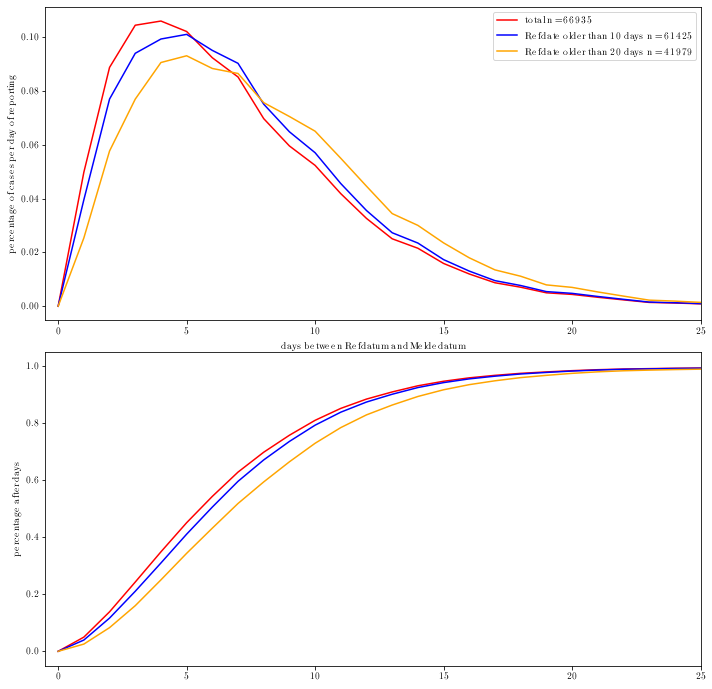

In [125]:
# Shape of delay between Refdate and Meldedatum
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.13,hspace=0.1,left=0.07,right=0.98,top=0.965,bottom=0.05)
ax = fig.add_subplot(211)
bx = fig.add_subplot(212)

for dt,c,l in zip([datetime.datetime(2020,4,13),datetime.datetime(2020,4,3),datetime.datetime(2020,3,24)],["red","blue","orange"],["total","Refdate older than 10 days","Refdate older than 20 days"]):
    mfsdf = fsdf[fsdf["Refdatum"]<dt]
    delay_cnt = mfsdf["delay"].value_counts()
    delay_cnt /= sum(delay_cnt)

    sdelay_cnt = list(delay_cnt.sort_index().index)
    delay = [0]+[delay_cnt[x] for x in sdelay_cnt]
    
    ax.plot(delay,color=c,label=l+" n = %d"%(len(mfsdf)))
    bx.plot(np.cumsum(np.array(delay)),color=c)

ax.legend(loc=1)
ax.set_ylabel("percentage of cases per day of reporting")
ax.set_xlabel("days between Refdatum and Meldedatum")
bx.set_ylabel("percentage after days")
ax.set_xlim([-0.5,25])
bx.set_xlim([-0.5,25])

pname = "EpiVsMeldungDelay"
plt.savefig("page/graph/%s.svg"%pname)
plt.savefig("%s.pdf"%pname)
plt.show()


# Results:
* RKI's Arcgis RefDatum follows RKI's daily situation-report EpiCurve data closely, but reports up to 1000 cases more per day.
* If Meldedatum == Refdatum is excluded Arcgis reports aproximately the same number of cases as EpiCurve from daily situation-report.
* RKI's 09.04.2020 bulletin EpiCurve matches the one from the 09.04.2020 situation-report. case-Peaks that are present in the situation report seem to be smoothed somehow. The transformation of (unknown date + symptomatic) --> imputated further smoothes the EpiCurve.
* RKI's Nowcast forcast based on EpiCurve from 09.04.2020 follws the EpiCurve+unknonws as published in the situation reports up to ~23.03.2020 (1k cases difference)
* The cases with Meldedatum == RefDatum from arcgis and (unknowns + symptomatic) from daily situation-report match in structure (weekend-dips), with the arcis' cases ~1/2 of daily sit-report's. The Structure of imputated cases from 09.04.2020 bulletin differs.
* cases by Meldedatum trails Refdate by > 5 days